https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning

In [113]:
import io
import os
import requests
from PIL import Image as im
from matplotlib import pyplot as plt
from IPython.display import HTML, display, Image

import math
import cv2 as cv
import numpy as np

In [3]:
size = 300
sigma = 0.33
rho_step = 1
new_size = 150
max_lines = 10
threshold = 50
score_thickness = 1
theta_step = np.pi / 180
angle_tolerance = 10 * np.pi / 180

In [117]:
image_file = 'popsike/46569.jpg'

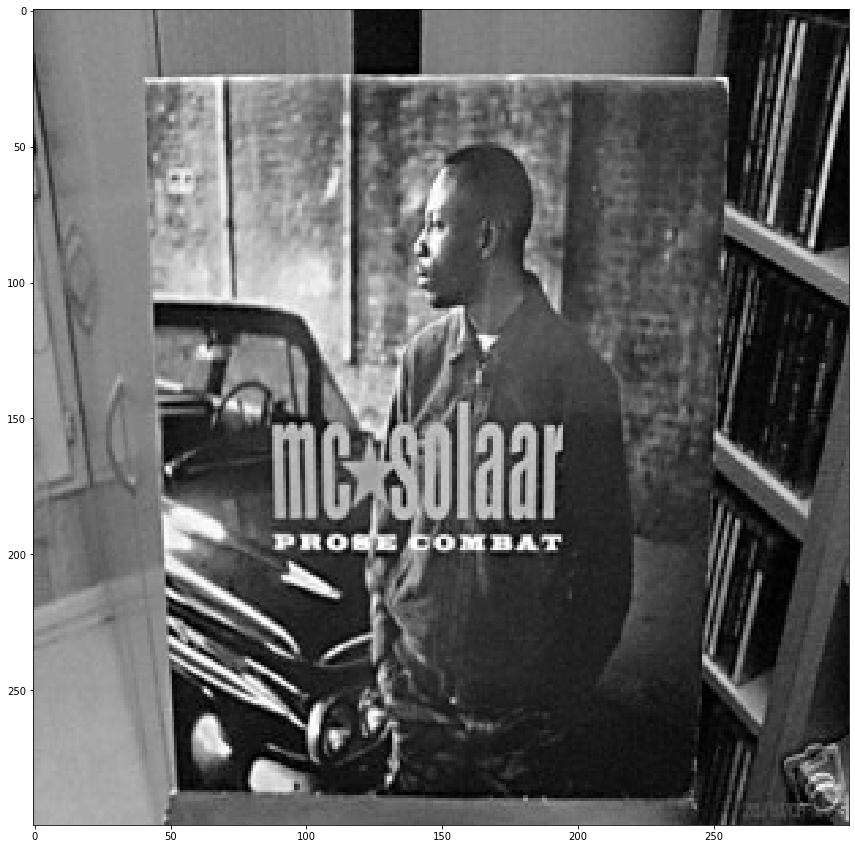

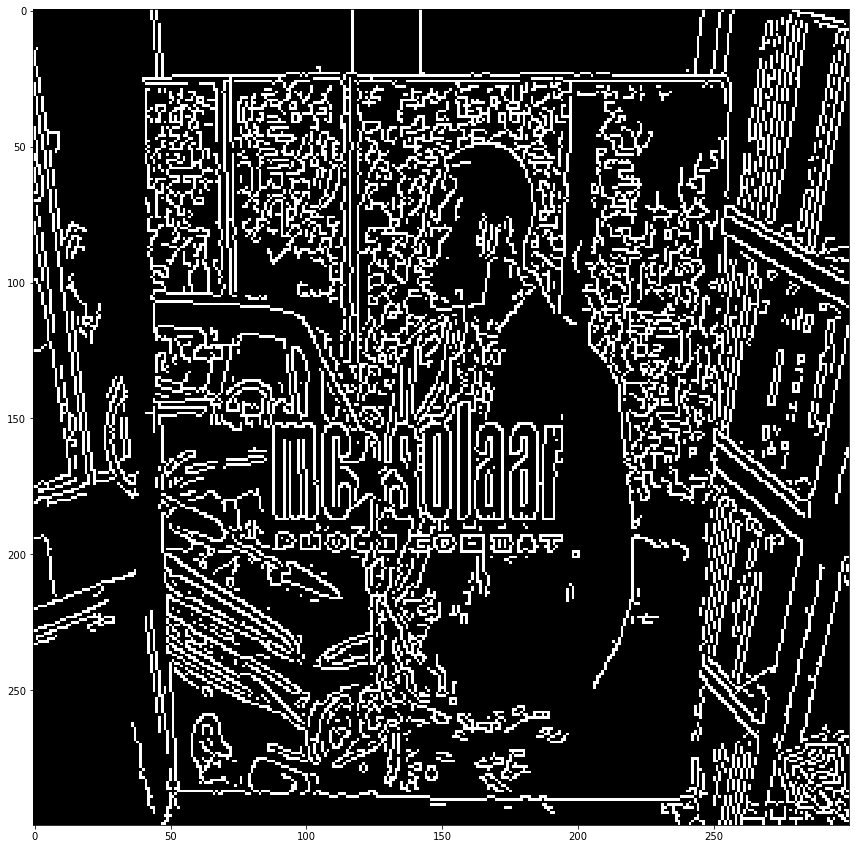

In [118]:
img = cv.imread(image_file, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (size,size), interpolation = cv.INTER_AREA) 

v = np.median(img)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(img, lower, upper)
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img, cmap="gray")
plt.show()
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(edges, cmap="gray")
plt.show()

In [119]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [(x0, y0)]

In [120]:
def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [121]:
lines = cv.HoughLines(edges, rho_step, theta_step, threshold)
horizontal_lines = [line for line in lines if np.pi / 2 - angle_tolerance < line[0][1] < np.pi / 2 + angle_tolerance or
                   3 * np.pi / 2 - angle_tolerance < line[0][1] < 3 * np.pi / 2 + angle_tolerance]
vertical_lines = [line for line in lines if line[0][1] < angle_tolerance or line[0][1] > 2 * np.pi - angle_tolerance or
                 np.pi - angle_tolerance < line[0][1] < np.pi + angle_tolerance]

In [122]:
intersections = segmented_intersections([horizontal_lines[:max_lines], vertical_lines[:max_lines]])

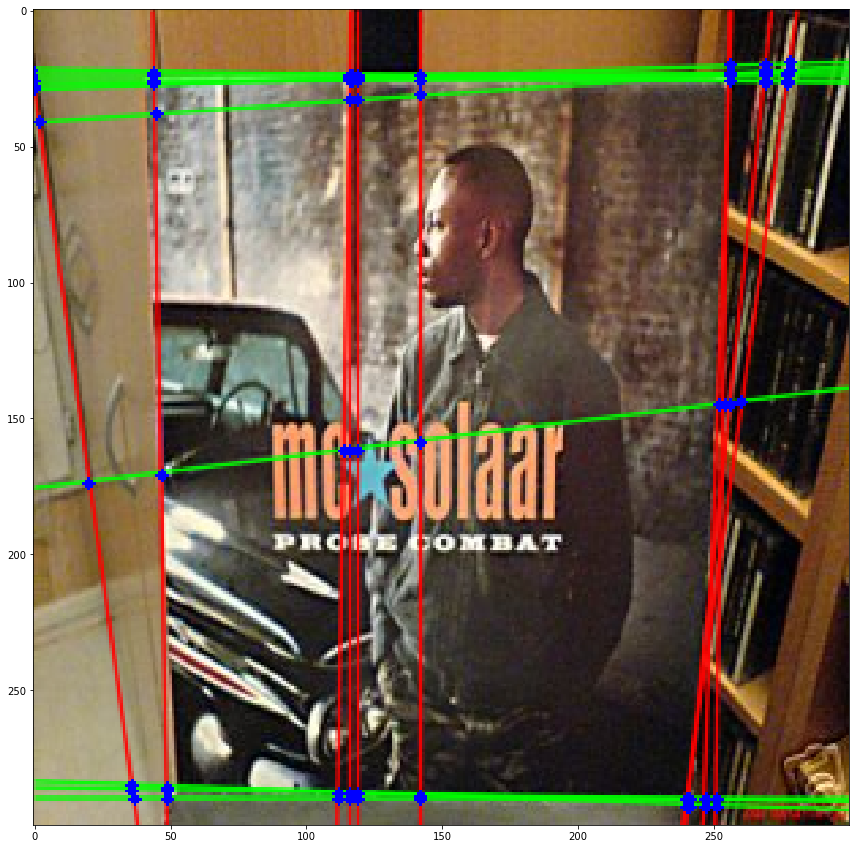

In [123]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

for line in vertical_lines[:max_lines]:
    rho = line[0][0]
    theta = line[0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(img, pt1, pt2, (255, 0, 0), 1, cv.LINE_AA)
    
for line in horizontal_lines[:max_lines]:
    rho = line[0][0]
    theta = line[0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(img, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)

for point in intersections:
    cv.circle(img, (point[0][0], point[0][1]), 2, (0, 0, 255), -1)
    
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

In [124]:
top_left_corners = set(point[0] for point in intersections if 0 < point[0][0] < size / 2 and 0 < point[0][1] < size / 2)
top_right_corners = set(point[0] for point in intersections if size > point[0][0] > size / 2 and 0 < point[0][1] < size / 2)
bottom_left_corners = set(point[0] for point in intersections if 0 < point[0][0] < size / 2 and size > point[0][1] > size / 2)
bottom_right_corners = set(point[0] for point in intersections if size > point[0][0] > size / 2 and size > point[0][1] > size / 2)

In [125]:
len(top_left_corners), len(top_right_corners), len(bottom_left_corners), len(bottom_right_corners)

(20, 20, 20, 8)

In [126]:
def score_line(edges, point_1, point_2):
    return np.tensordot(edges, cv.line(np.zeros(edges.shape), point_1, point_2, (255,), score_thickness, cv.LINE_AA))

In [127]:
top_lines = sorted([
    (score_line(edges, top_left_corner, top_right_corner), top_left_corner, top_right_corner)
    for top_left_corner in top_left_corners
    for top_right_corner in top_right_corners
], reverse=True)

In [128]:
right_lines = sorted([
    (score_line(edges, top_right_corner, bottom_right_corner), top_right_corner, bottom_right_corner)
    for top_right_corner in top_right_corners
    for bottom_right_corner in bottom_right_corners
], reverse=True)

In [129]:
bottom_lines = sorted([
    (score_line(edges, bottom_right_corner, bottom_left_corner), bottom_right_corner, bottom_left_corner)
    for bottom_right_corner in bottom_right_corners
    for bottom_left_corner in bottom_left_corners
], reverse=True)

In [130]:
left_lines = sorted([
    (score_line(edges, bottom_left_corner, top_left_corner), bottom_left_corner, top_left_corner)
    for bottom_left_corner in bottom_left_corners
    for top_left_corner in top_left_corners
], reverse=True)

In [131]:
len(top_lines), len(right_lines), len(bottom_lines), len(left_lines)

(400, 160, 160, 400)

In [132]:
quadrilaterals = sorted(
    [(top_line[0] + right_line[0] + bottom_line[0] + left_line[0], top_line[1],
      right_line[1], bottom_line[1], left_line[1]) for top_line in top_lines
     for right_line in right_lines if right_line[1] == top_line[2]
     for bottom_line in bottom_lines if bottom_line[1] == right_line[2]
     for left_line in left_lines
     if left_line[1] == bottom_line[2] and left_line[2] == top_line[1]],
    reverse=True)

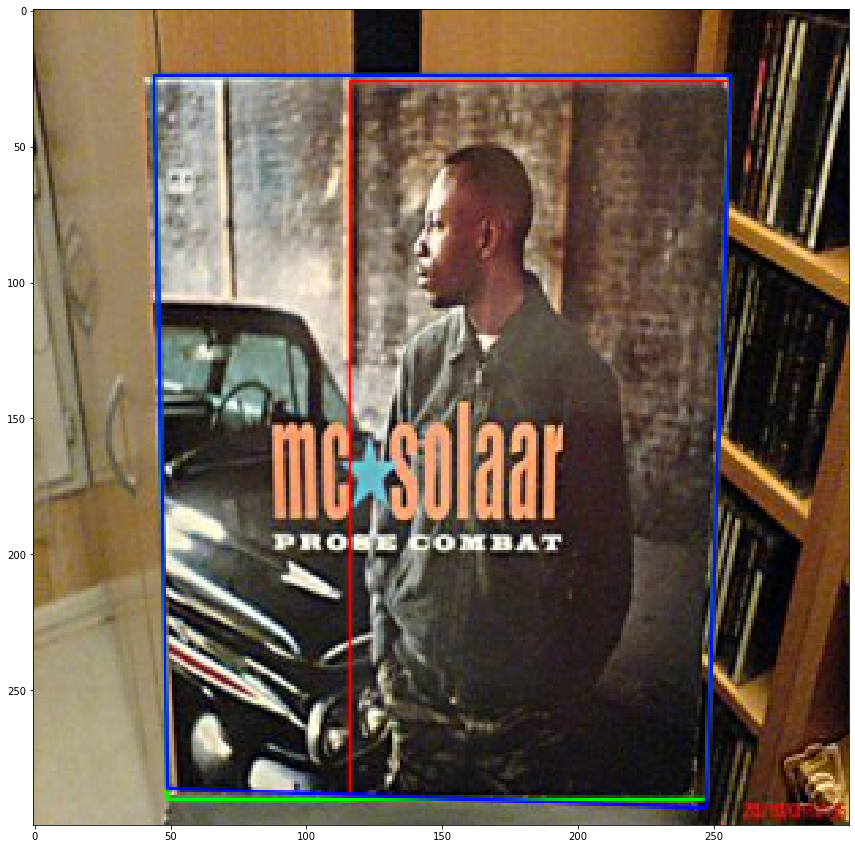

In [133]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

cv.line(img, quadrilaterals[0][1], quadrilaterals[0][2], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][2], quadrilaterals[0][3], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][3], quadrilaterals[0][4], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][4], quadrilaterals[0][1], (255, 0, 0), 1, cv.LINE_AA)

if len(quadrilaterals) > 1:
    cv.line(img, quadrilaterals[1][1], quadrilaterals[1][2], (0, 255, 0), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[1][2], quadrilaterals[1][3], (0, 255, 0), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[1][3], quadrilaterals[1][4], (0, 255, 0), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[1][4], quadrilaterals[1][1], (0, 255, 0), 1, cv.LINE_AA)

if len(quadrilaterals) > 2:
    cv.line(img, quadrilaterals[2][1], quadrilaterals[2][2], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[2][2], quadrilaterals[2][3], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[2][3], quadrilaterals[2][4], (0, 0, 255), 1, cv.LINE_AA)
    cv.line(img, quadrilaterals[2][4], quadrilaterals[2][1], (0, 0, 255), 1, cv.LINE_AA)

fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

In [134]:
M = cv.getPerspectiveTransform(np.float32([
    [quadrilaterals[0][1][0], quadrilaterals[0][1][1]],
    [quadrilaterals[0][2][0], quadrilaterals[0][2][1]],
    [quadrilaterals[0][3][0], quadrilaterals[0][3][1]],
    [quadrilaterals[0][4][0], quadrilaterals[0][4][1]],
]), np.float32([
    [0, 0],
    [new_size, 0],
    [new_size, new_size],
    [0, new_size]
]))

In [135]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
new_img = cv.warpPerspective(img, M, (size, size))[:new_size, :new_size, :]

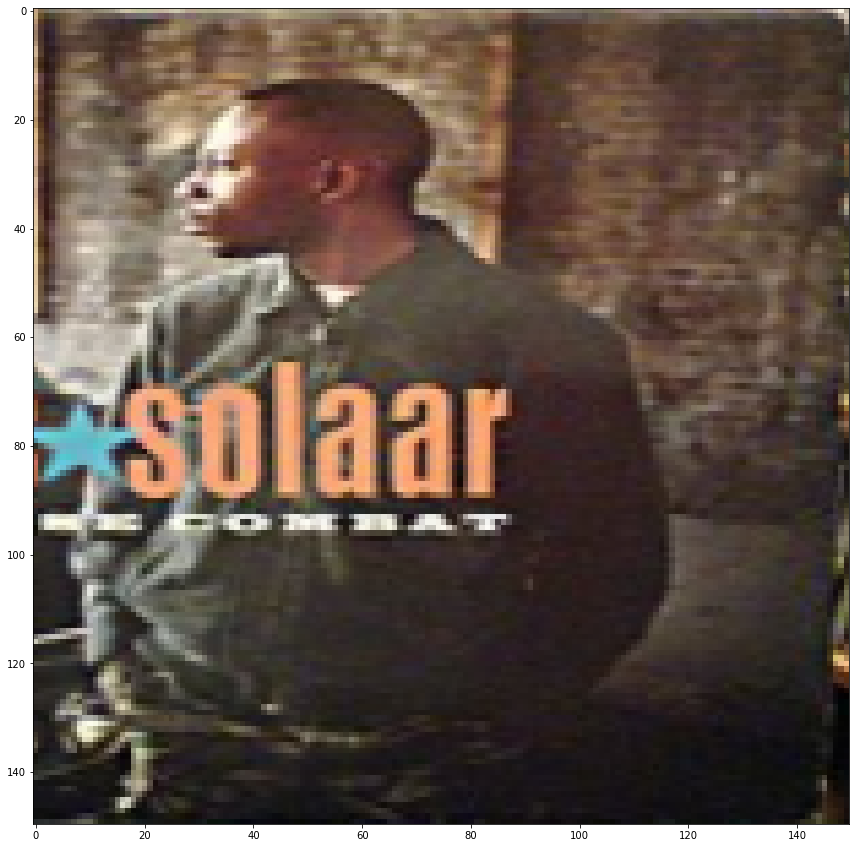

In [136]:
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(new_img)
plt.show()

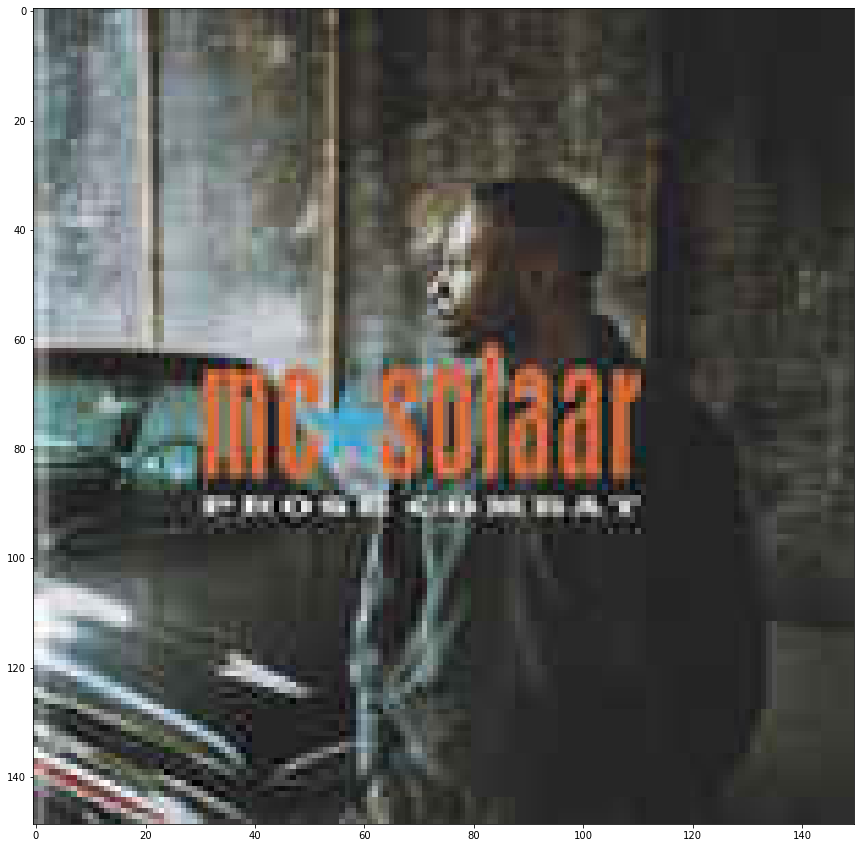

In [137]:
img = cv.imread(f'thumbs/thumb_{image_file[8:-4]}.jpg', cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

In [102]:
im.fromarray(new_img).save(f'popsike/cropped_{image_file[8:-4]}.png')

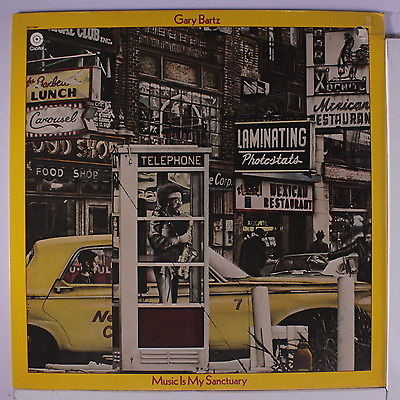

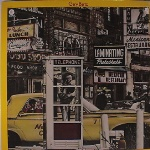

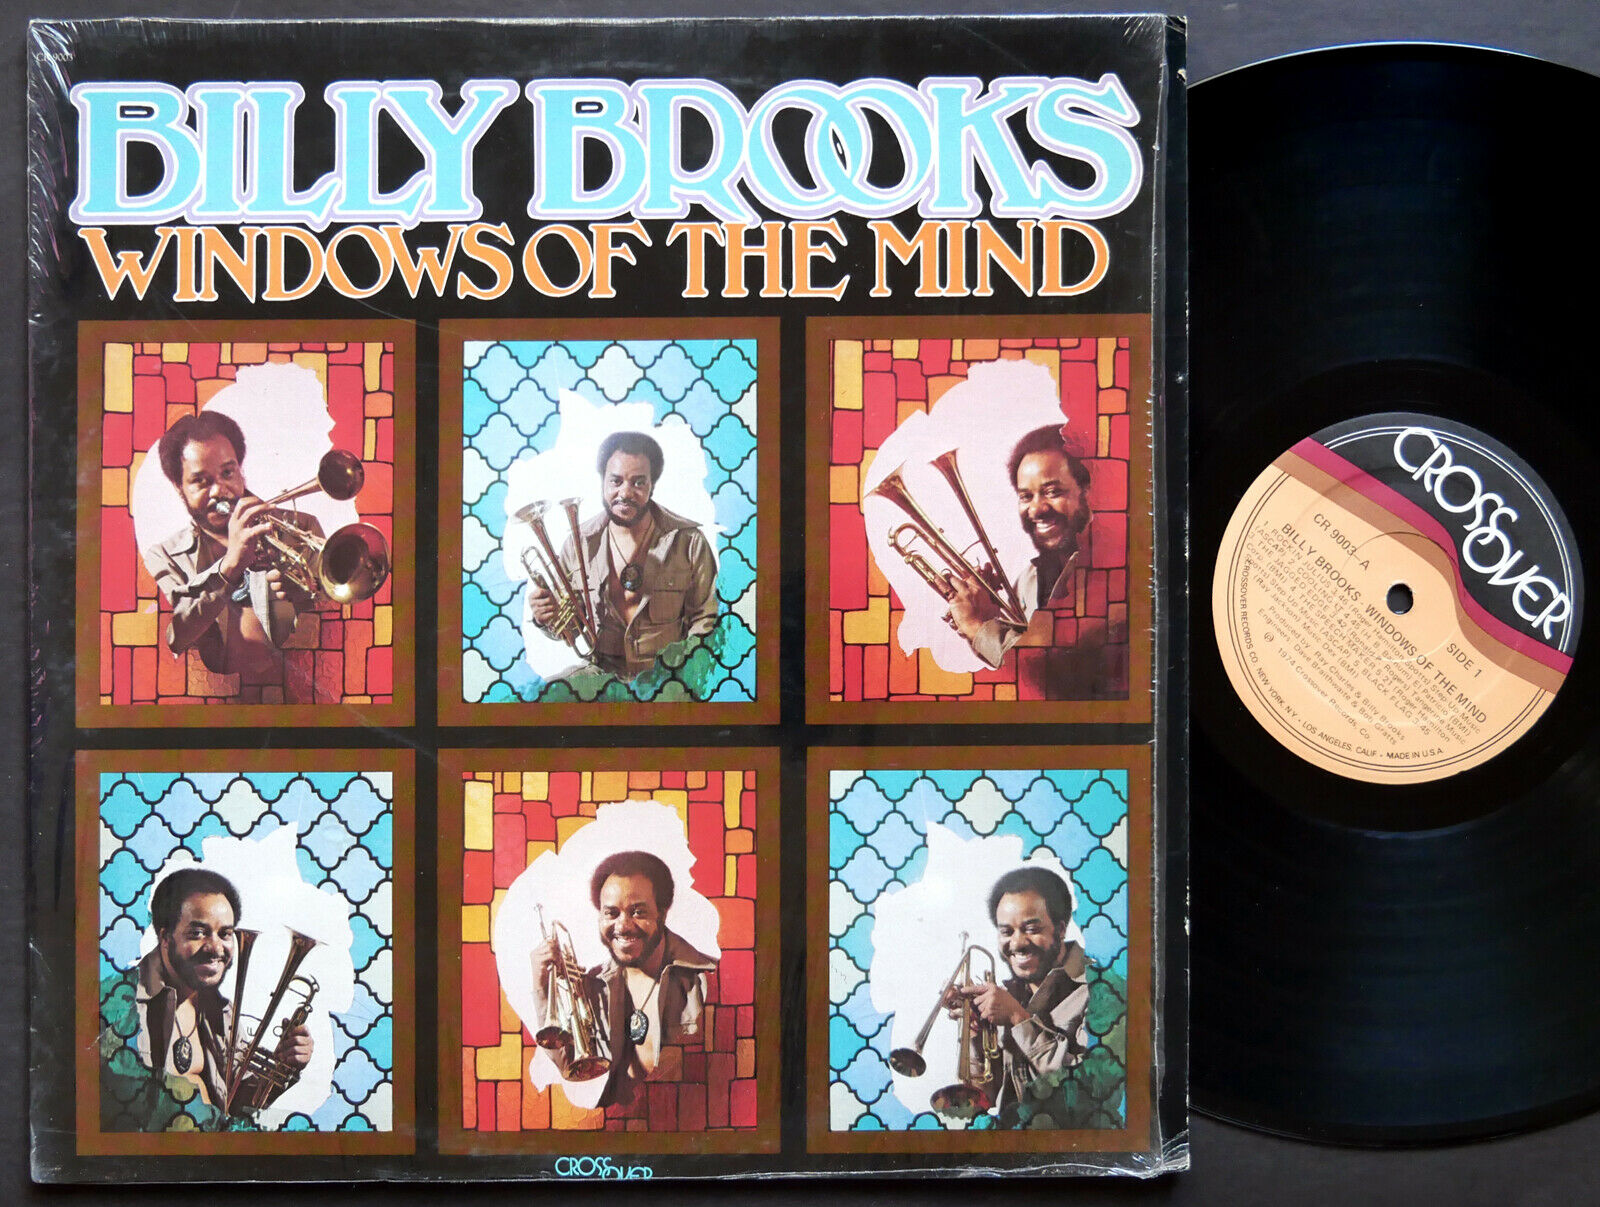

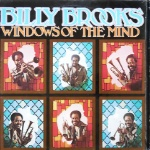

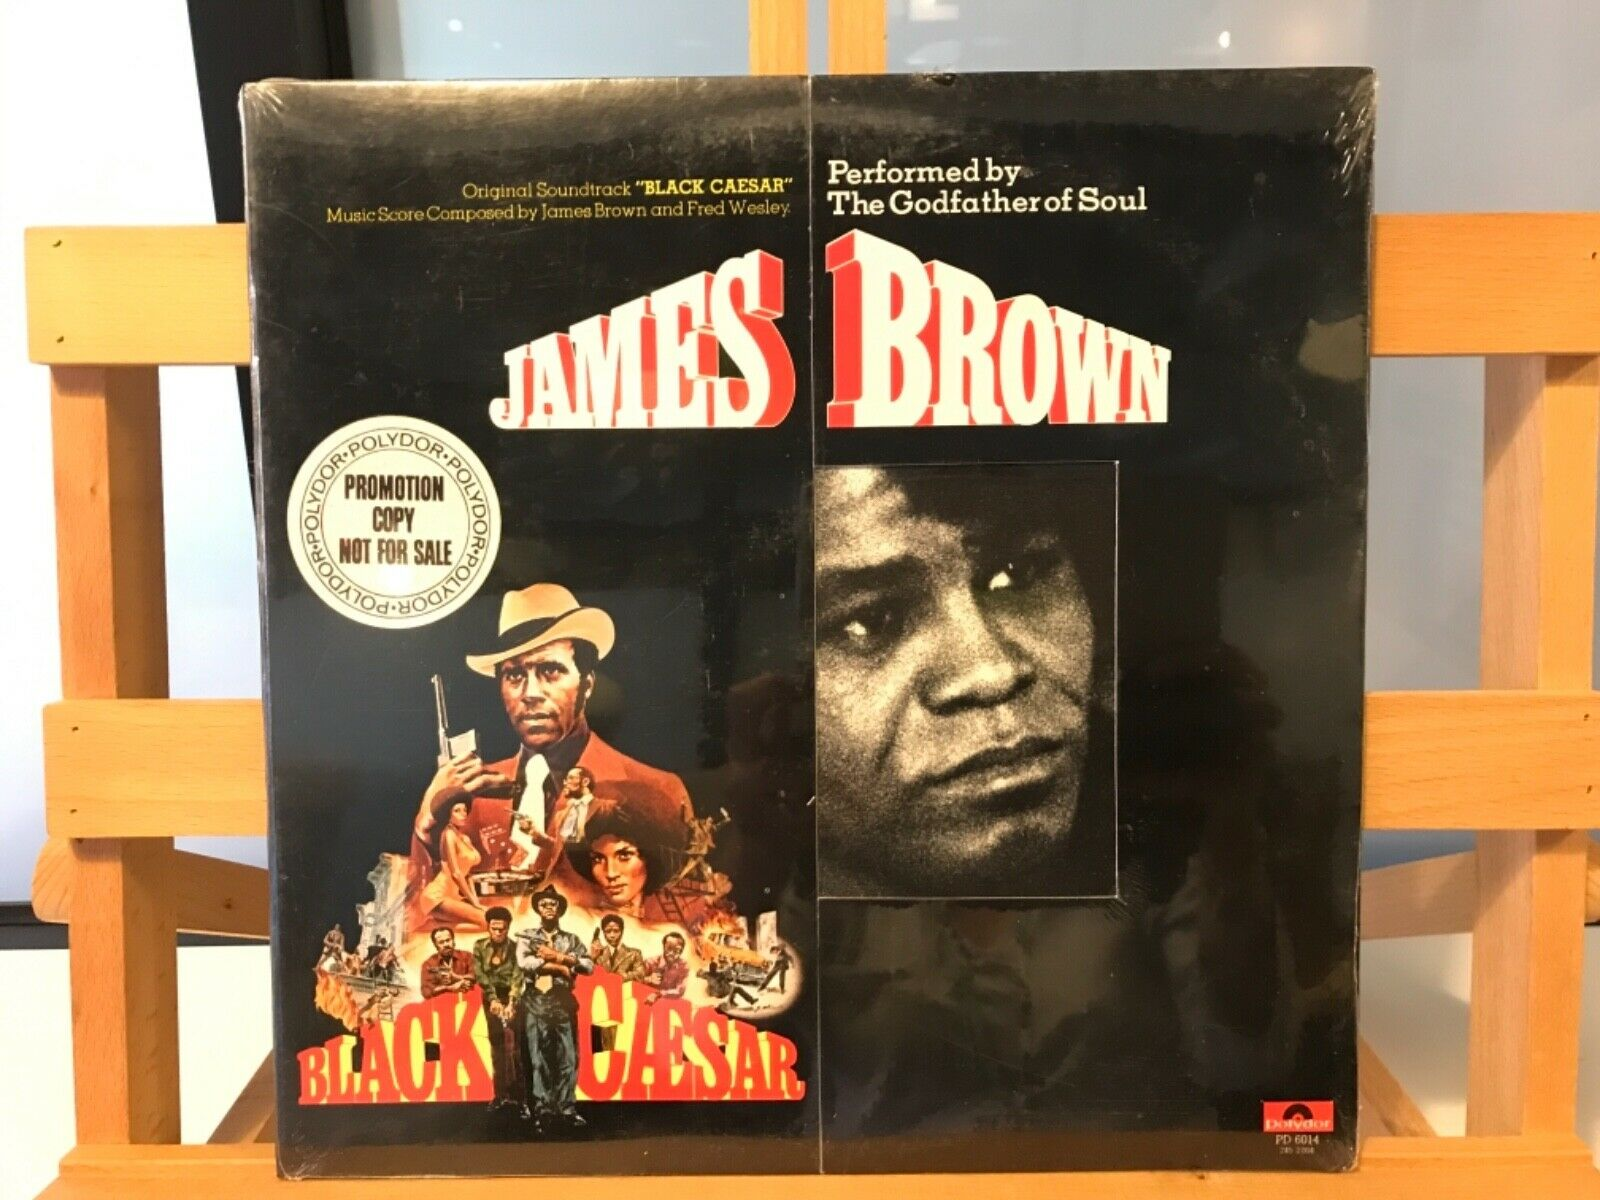

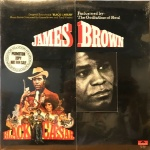

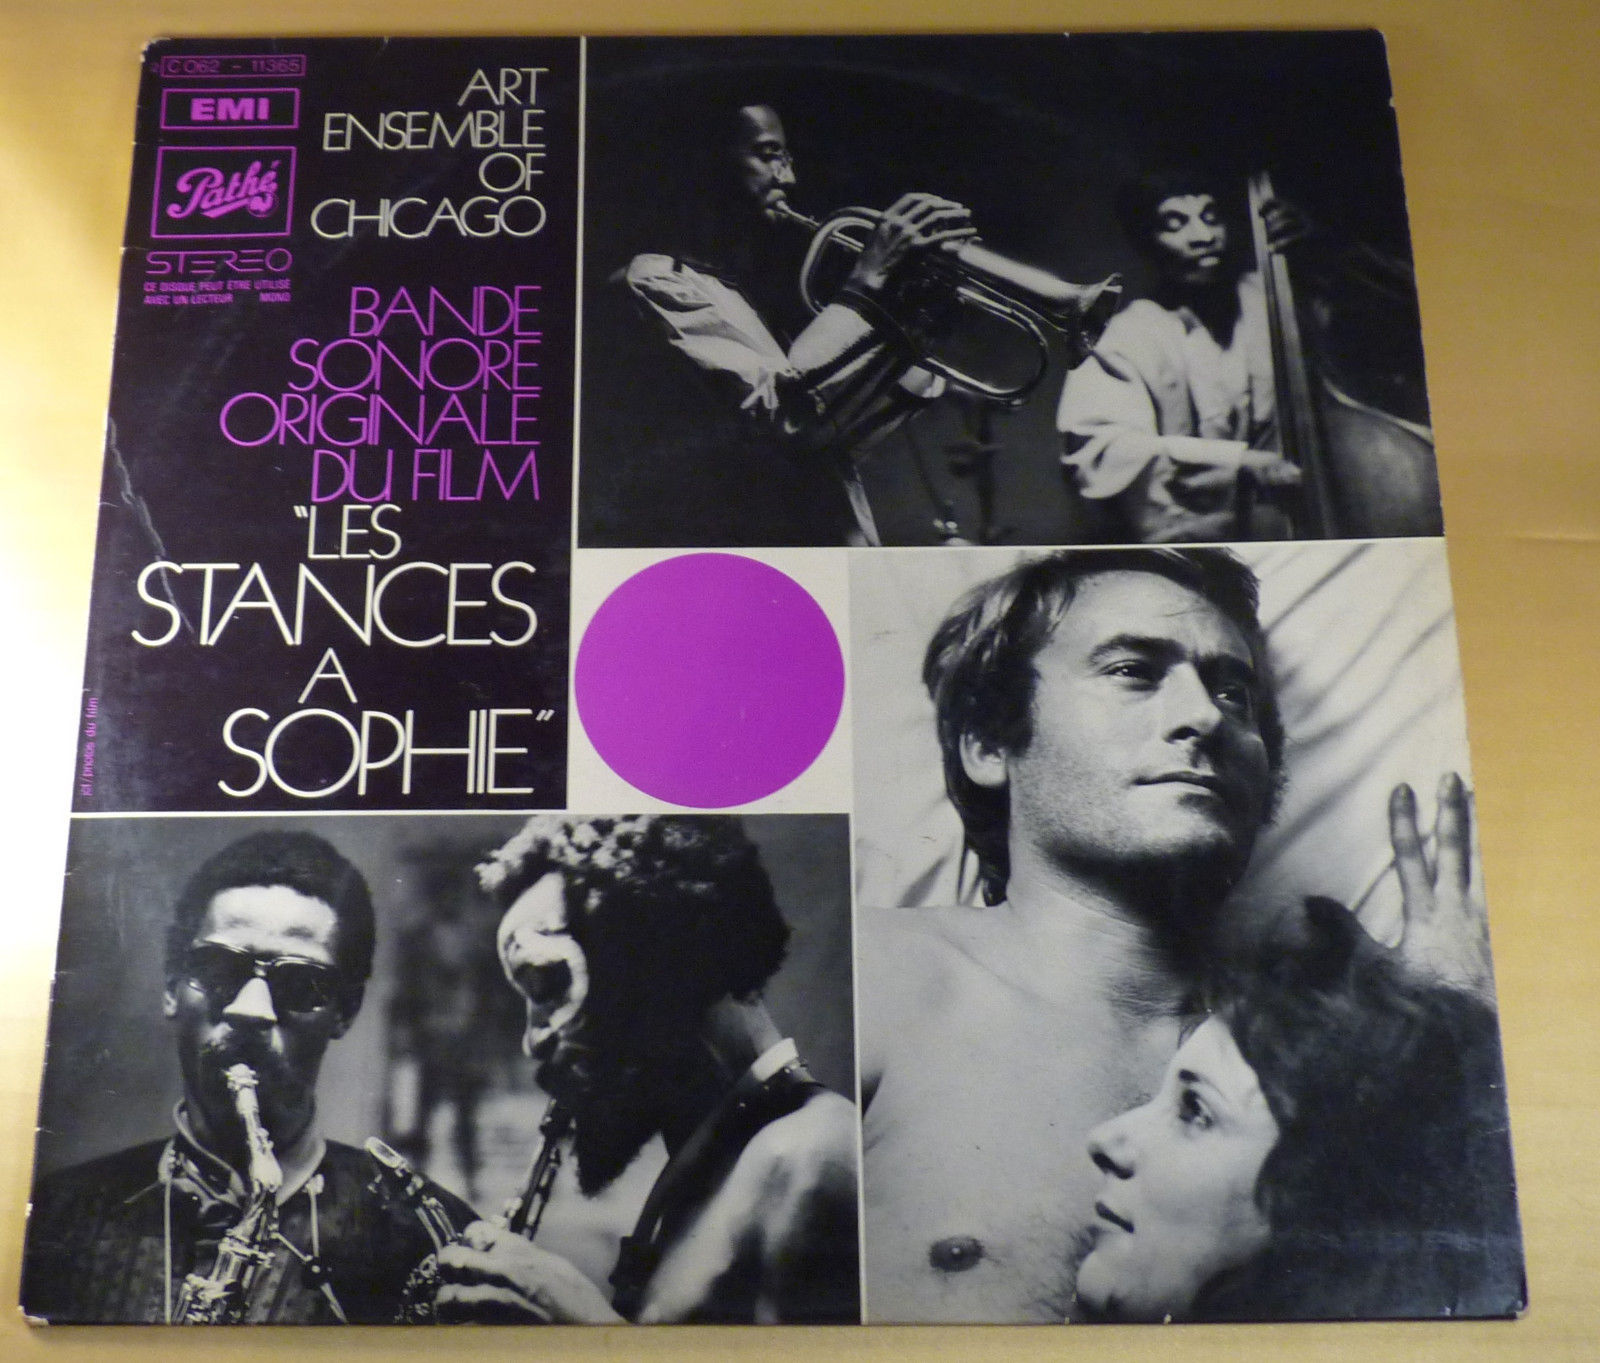

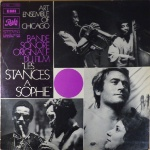

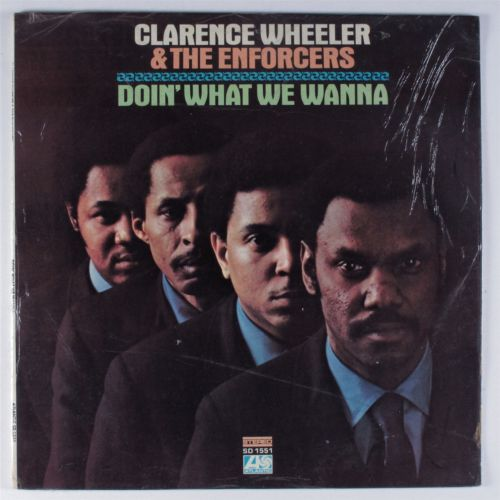

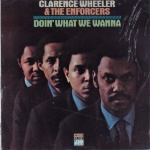

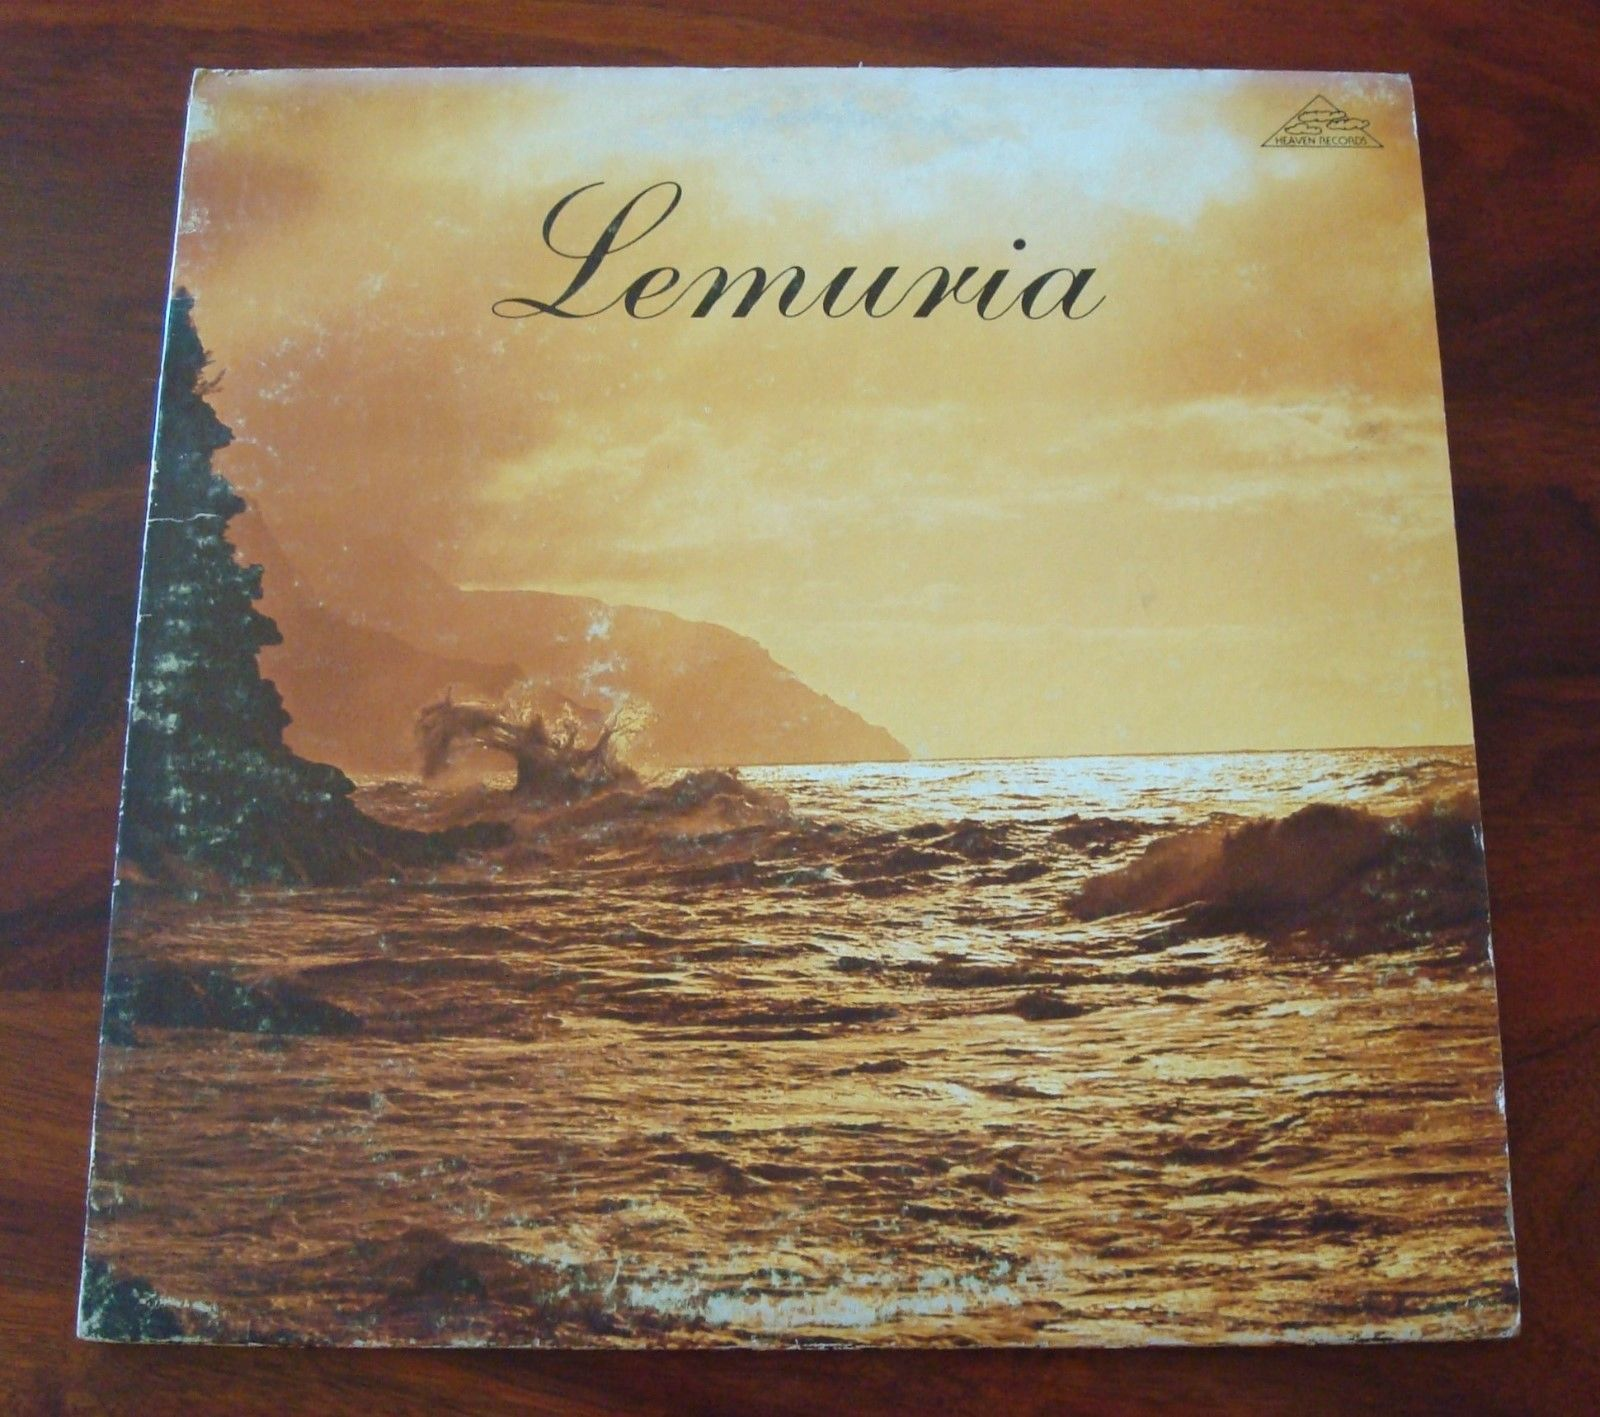

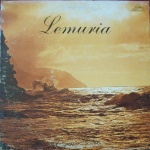

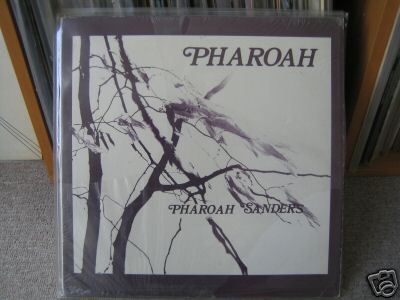

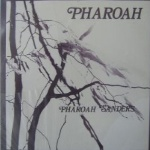

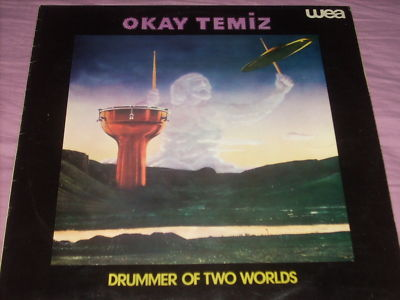

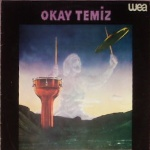

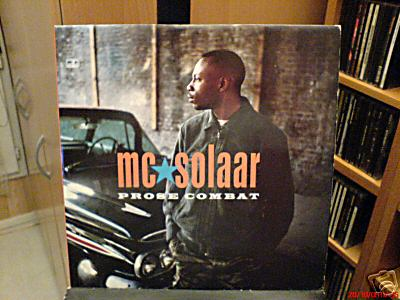

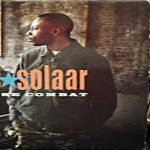

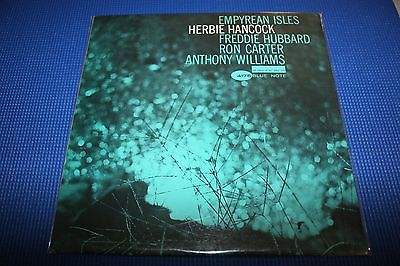

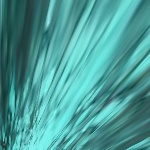

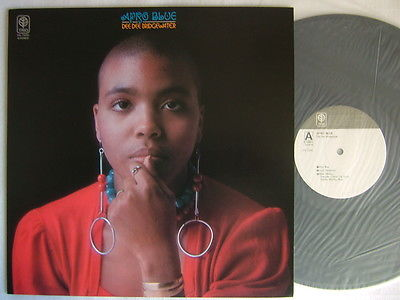

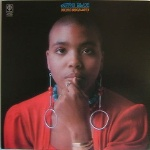

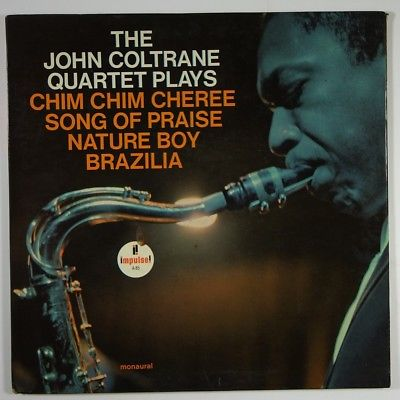

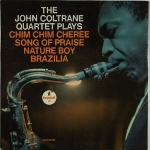

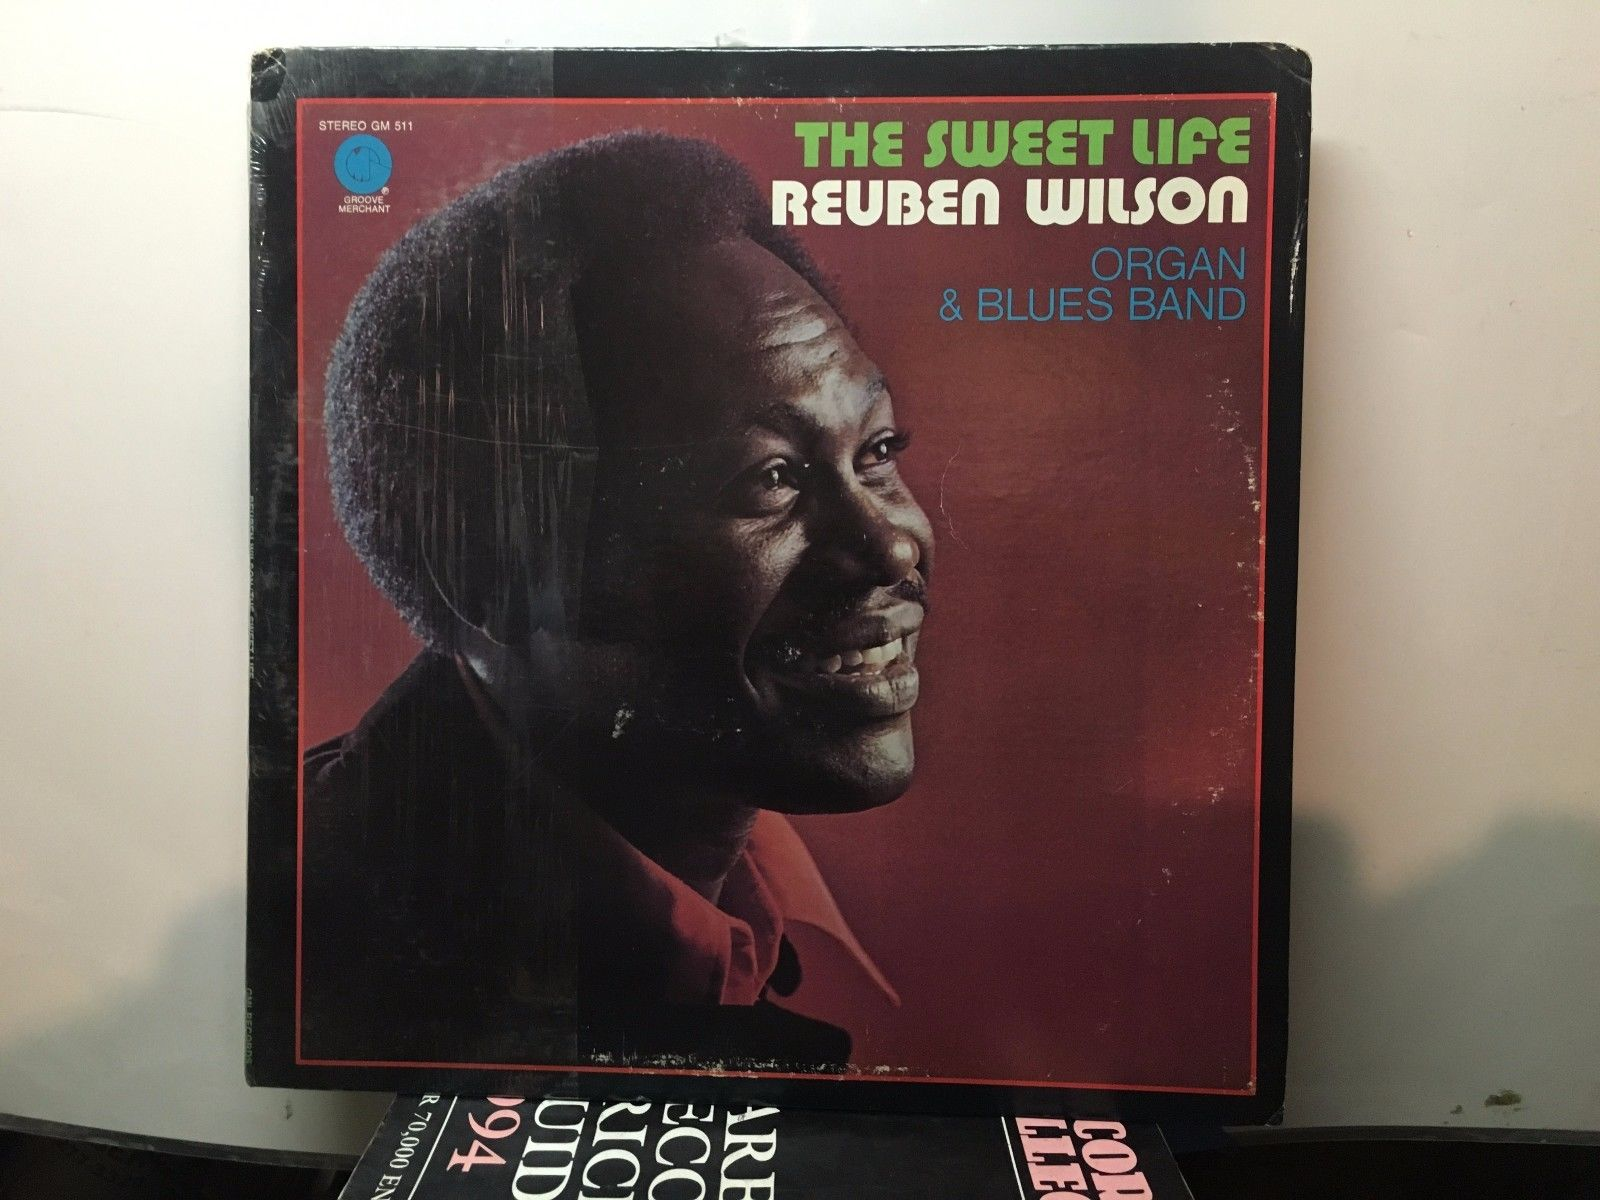

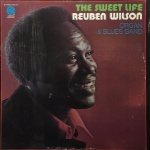

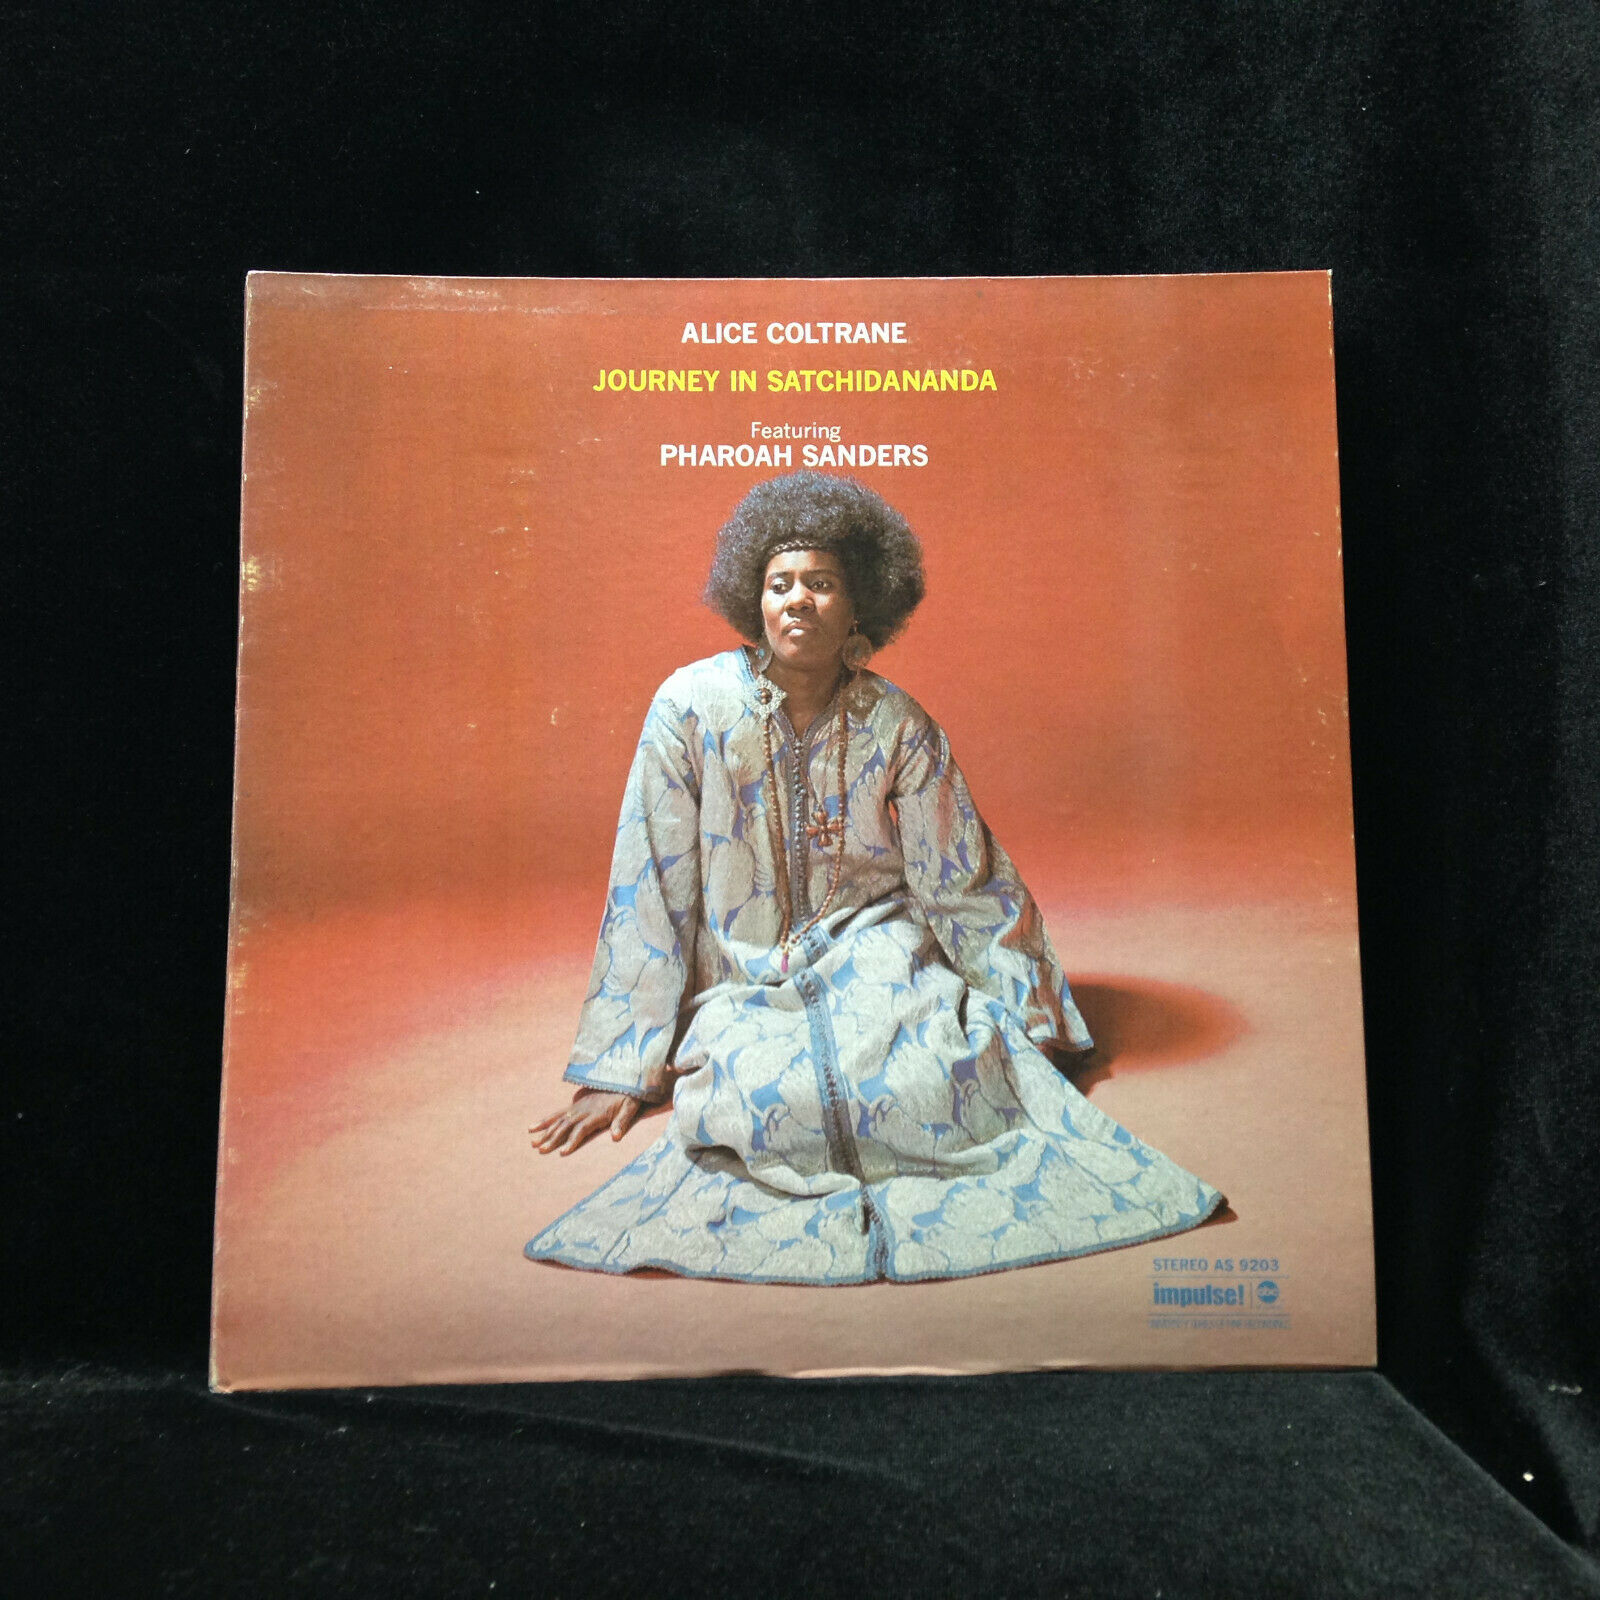

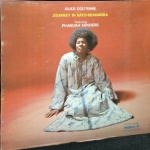

In [116]:
for image in os.listdir('popsike'):
    if 'cropped' in image or 'jpg' not in image:
        continue
    r = requests.post(
        'http://127.0.0.1:8000/uploadfile/',
        files={'file': (image, open(f'popsike/{image}', 'rb'), 'image/jpeg')})
    display(
        HTML(f'<h2>{image}</h2>'),
        Image(open(f'popsike/{image}', 'rb').read(), width=200, height=200),
        Image(io.BytesIO(r.content).read(), width=200, height=200),
    )

* Speed up by calculating score over smallest area containing line
* Lower resolution corner points
* top_lines{point_1[0] * size + point_1[1]} = (point_1, [(score, point_2), ...])

In [ ]:
def square_score(top_left, top_right, bottom_right, bottom_left):
    # ??????
    pass